# eFEDS BCGs and Fermi Blazars report

In [1]:
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [2]:
tol_coord = 3                       #tolerance of crossmatch in arcsec

#-----------------------------------------------------------------------

tol_coord = tol_coord/3600  

#ETHER sample
ethercat = fits.open('../ETHER/ETHER.fits')
#bcg sample
bcgcat = fits.open('../eROSITA/eFEDS_BCGs_mbh.fits')
blazarcat = fits.open('../FITS/central_engines_v1.fits')

cols = ethercat[1].columns
col_names = cols.names
ethercat =  ethercat[1].data                    #ETHER catalogue
bcgcat = bcgcat[1].data                         #BCGs catalogue
blazarcat = blazarcat[6].data                     #Blazars catalogue

bcg_names = bcgcat['Name_Cluster']
blazar_names = blazarcat['4FGL_Source_Name']
ra_ether = ethercat['RA']
dec_ether = ethercat['DEC']

print('BCG sources: {}\nBlazar sources: {}'.format(len(bcg_names), len(blazar_names)))

BCG sources: 43
Blazar sources: 684


BCG low z: 0.164
Blazar low z: 0.027000000700354576


Text(0.5, 0, 'Redshift')

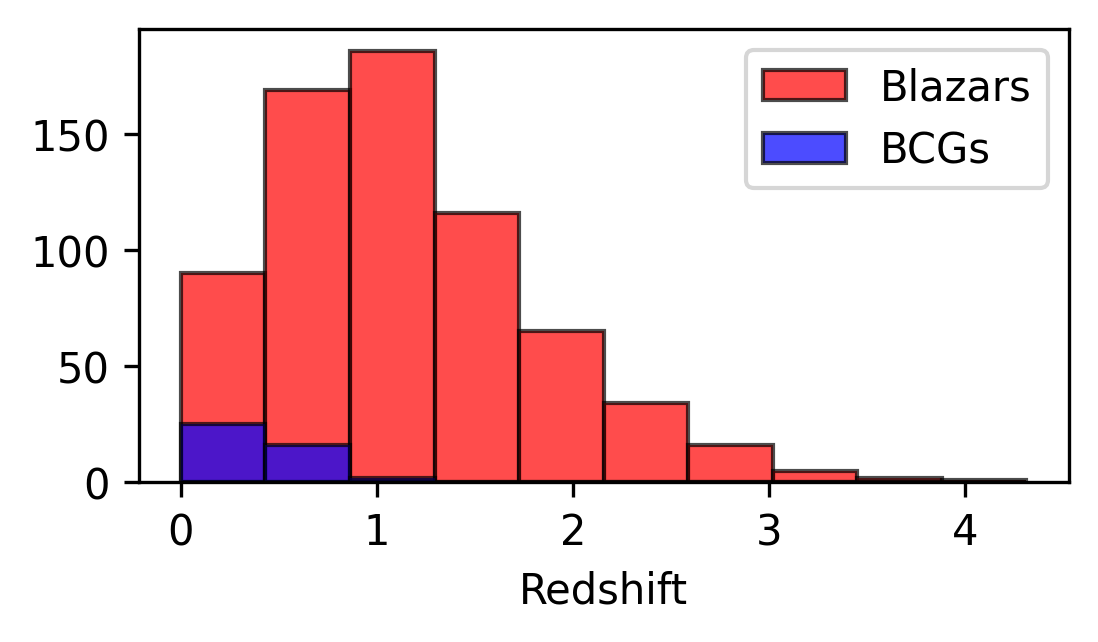

In [3]:
z_bcg = bcgcat['z']
z_blazar = blazarcat['Redshift']
print('BCG low z: {}\nBlazar low z: {}'.format(min(z_bcg),min(z_blazar)))
bint = np.linspace(0, max(max(z_bcg),max(z_blazar)), 11)

plt.figure(dpi=300, figsize=(4,2))
  
plt.hist(
    z_blazar, 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='r', 
    label='Blazars', 
    edgecolor='k')
plt.hist(
    z_bcg, 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='b', 
    label='BCGs', 
    edgecolor='k')
plt.legend()
plt.xlabel('Redshift')

Text(0.5, 0, 'Redshift')

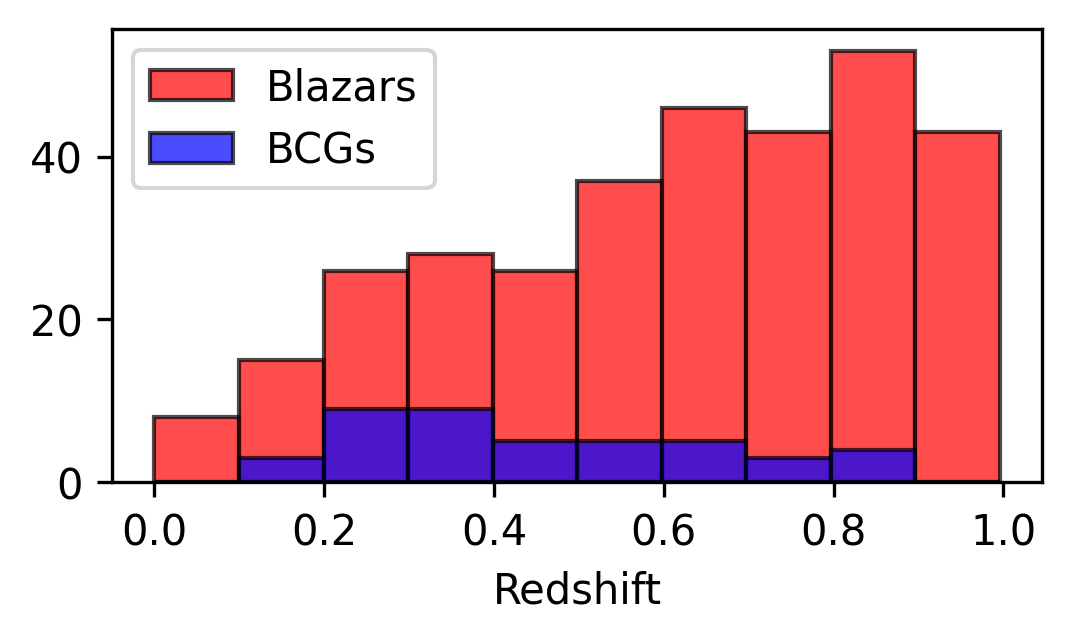

In [4]:
bint = np.linspace(0, max(max(z_bcg[z_bcg<1]),max(z_blazar[z_blazar<1])), 11)

plt.figure(dpi=300, figsize=(4,2))
  
plt.hist(
    z_blazar[z_blazar<1], 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='r', 
    label='Blazars', 
    edgecolor='k')
plt.hist(
    z_bcg[z_bcg<1], 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='b', 
    label='BCGs', 
    edgecolor='k')
plt.legend()
plt.xlabel('Redshift')

Text(0.5, 0, 'log [$M_{BH}/M_{\\odot}$]')

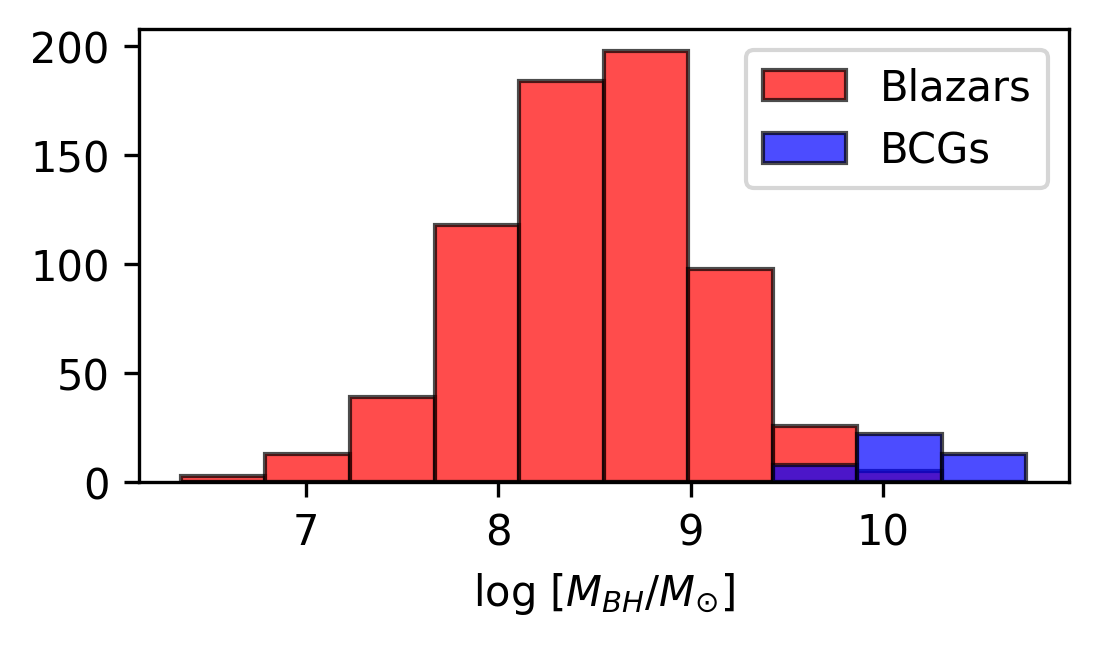

In [5]:
mbh_bcg = bcgcat['Mbh']
mbh_blazar = blazarcat['log10BHM']
bint = np.linspace(min(min(mbh_bcg),min(mbh_blazar)), max(max(mbh_bcg),max(mbh_blazar)), 11)

plt.figure(dpi=300, figsize=(4,2))
  
plt.hist(
    mbh_blazar, 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='r', 
    label='Blazars', 
    edgecolor='k')
plt.hist(
    mbh_bcg, 
    bins=bint, 
    alpha=0.7,                                              #Se plotea el histograma
    color='b', 
    label='BCGs', 
    edgecolor='k')
plt.legend()
plt.xlabel(r'log [$M_{BH}/M_{\odot}$]')

Text(0, 0.5, 'log [$M_{BH}/M_{\\odot}$]')

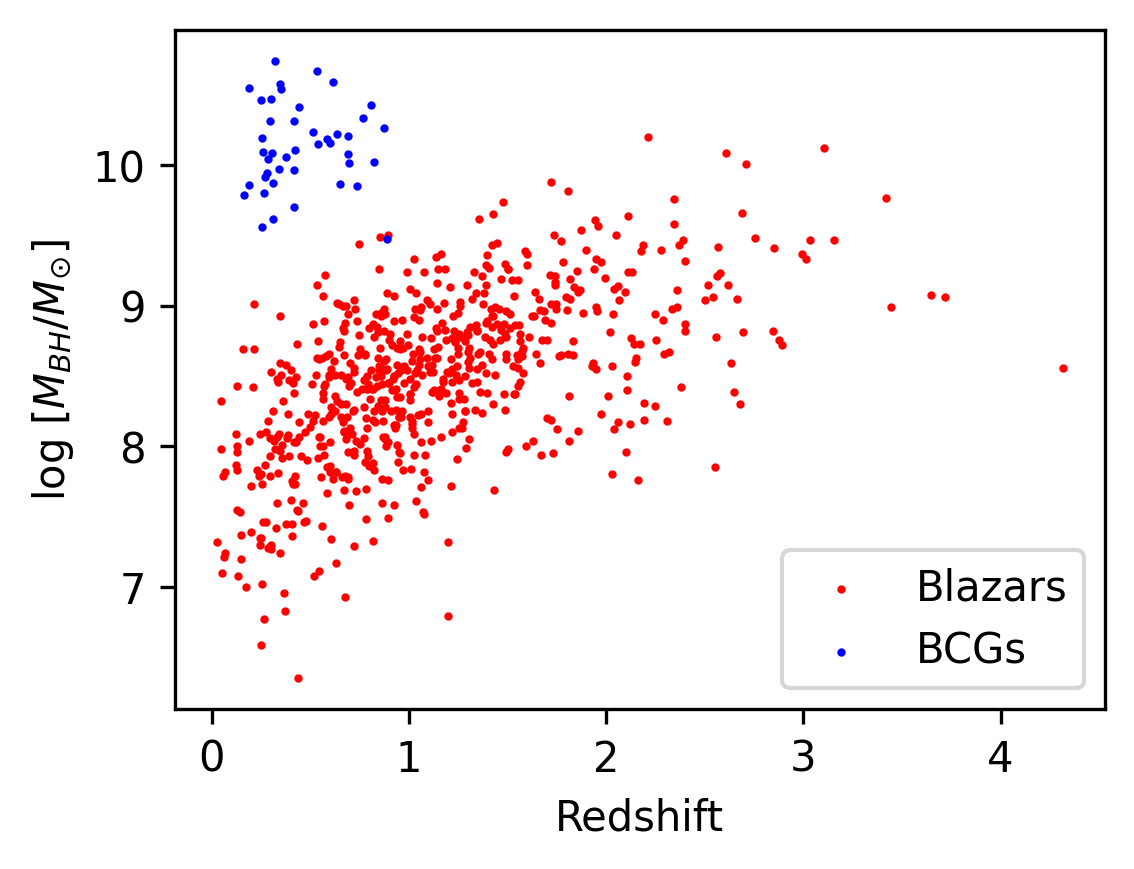

In [6]:
plt.figure(dpi=300, figsize=(4,3))
  
plt.scatter(z_blazar,
    mbh_blazar,
    color='r', 
    label='Blazars',
    s=1)
plt.scatter(z_bcg,
    mbh_bcg, 
    color='b', 
    label='BCGs',
    s=1)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel(r'log [$M_{BH}/M_{\odot}$]')

# eFEDS BCGs xmatch

First, let's run a simple xmatch for the eFEDS BCGs. In past xmatches, less than 1% of the complete eFEDS catalogue match with ETHER sources, so I don't expect a lot of matches this time.

In [7]:
ids = []
final_names = []
print('Crossmatching with a tolerance of {} arc-second(s) differennce'.format(tol_coord*3600))
count = 0  
for i in np.arange(len(bcg_names)):
    matches = 0
    name = bcg_names[i]
    ra_bcg = bcgcat['RA'][i]
    dec_bcg = bcgcat['DEC'][i]
        
    dist = np.sqrt((ra_bcg-ra_ether)**2 + (dec_bcg-dec_ether)**2)       #Substraction to analyze

    cond = (dist==min(dist))*(dist<=tol_coord)                  #Boolean array of condition after match
    cond = [i for i, x in enumerate(cond) if x]                 #Takes the index of True values only
        
    for i in cond:
        final_names.append(name)
        ids.append(i)
        matches += 1
        count += 1
        
    if matches>0:
        print('Source {} has {} match(es)'.format(name, matches))

print('Total matches: {}'.format(count))

Crossmatching with a tolerance of 3.0 arc-second(s) differennce
Total matches: 0


For my surprise, 0 matches. I expected at least a few, but yeah... No much analyze to do here, but at least all of this BCGs are new possible additions to the ETHER sample.

# Fermi Blazars xmatch

For the Fermi Blazars, the authors provided a FITS file WITH NO COORDINATES!!! (???), so I had to do 2 matches for this instance, one with the original Fermi catalogue just by names to obtain the coordinates and then with the ETHER sample.

In [8]:
fermicat = fits.open('../FITS/gll_psc_v27.fit')
fermicat = fermicat[1].data

fermi_names = fermicat['Source_Name']
fermi_ra = fermicat['RAJ2000']
fermi_dec = fermicat['DEJ2000']

names2match = '4FGL ' + blazar_names
mbh2match = mbh_blazar

Now that the names are setted, I can run the first xmatch.

In [9]:
blazar_name = []
blazar_ra = []
blazar_dec = []
blazar_mbh = []

count = 0  
for i in np.arange(len(names2match)):
    name_blazar = names2match[i]
    mbh_blazar = mbh2match[i]
    
    cond = name_blazar==fermi_names
    cond = [i for i, x in enumerate(cond) if x]                 #Takes the index of True values only
        
    for i in cond:
        blazar_name.append(name_blazar)
        blazar_ra.append(fermi_ra[i])
        blazar_dec.append(fermi_dec[i])
        blazar_mbh.append(mbh_blazar)
        count += 1
        
print('{} out of {} total blazars match!'.format(count, len(blazar_names)))

682 out of 684 total blazars match!


In [10]:
blazar_info = pd.DataFrame(list(zip(blazar_name,blazar_ra,blazar_dec,blazar_mbh)), columns=['Name','RA','DEC','Mbh'])
blazar_info

,Name,RA,DEC,Mbh
0,4FGL J0001.5+2113,0.381500,21.218300,7.54
1,4FGL J0004.3+4614,1.075700,46.242699,8.36
2,4FGL J0004.4-4737,1.109100,-47.623299,8.28
3,4FGL J0006.3-0620,1.599200,-6.349300,8.93
4,4FGL J0010.6+2043,2.650200,20.733200,7.86
...,...,...,...,...
677,4FGL J2354.9+8151,358.741211,81.866600,8.83
678,4FGL J2357.4-0152,359.367401,-1.870300,7.33
679,4FGL J2358.3+3830,359.588287,38.509701,7.39
680,4FGL J2358.3-1021,359.582214,-10.361600,8.93


Now that I've a functional catalogue, it's time to run the second xmatch.

In [11]:
blazar_data = []

print('Crossmatching with a tolerance of {} arc-second(s) differennce'.format(tol_coord*3600))
count = 0  
for i in np.arange(len(blazar_name)):
    matches = 0
    name = blazar_info['Name'][i]
    ra_fermi = blazar_info['RA'][i]
    dec_fermi = blazar_info['DEC'][i]
        
    masking = (dec_ether>(dec_fermi-tol_coord))*(dec_ether<(dec_fermi+tol_coord))

    ethercat_masked = ethercat[masking]

    ra_masked = ethercat_masked['RA']
    dec_masked = ethercat_masked['DEC']

    dist = np.sqrt((ra_fermi-ra_masked)**2 + (dec_fermi-dec_masked)**2)       #Substraction to analyze

    cond = dist<=tol_coord                          #Boolean array of condition after match
    cond = [i for i, x in enumerate(cond) if x]     #Takes the index of True values only
        
    for i in cond:
        blazar_data.append(np.array(ethercat_masked[i]))
        matches += 1
        count += 1
        
    if matches>0:
        print('Source {} has {} match(es)'.format(name, matches))

print('Total matches: {}'.format(count))

Crossmatching with a tolerance of 3.0 arc-second(s) differennce
Source 4FGL J0442.6-0017 has 1 match(es)
Source 4FGL J1208.9+5441 has 1 match(es)
Source 4FGL J2232.6+1143 has 1 match(es)
Total matches: 3
